In [21]:
import numpy as np
import matplotlib 
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import random
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

In [3]:
# Function to generate the Dataset for a known hypothesis
# Assumptions: Range of values on the x and y axis are the same
#              Code is only for classifying data in 2D
def gen_data_perceptron(llim,ulim,target_weight_3D,N):
    
    """
    llim: a scalar defining the lower limit on the x and y axis
    ulim: a scalar defining the upper limit on the x and y axis
    target_weight: a column vector of 3x1 listing the known weights used for generating the target hypothesis
    N: Total number of data points
    Output: Returns a numpy array of Nx4 with the first column being all 1s, second and third column 
                     consists of N points generated uniformly between llim and ulim and the 4th column being 
                     the labels given as per the target weight
    """
    x1_sample = np.append(np.ones((N,1)),np.random.uniform(llim,ulim,N).reshape(N,1),axis=1)
    x2_sample = np.random.uniform(llim,ulim,N).reshape(N,1)
    data_partial = np.append(x1_sample,x2_sample,axis=1)    
    target = np.dot(data_partial,target_weight_3D)
    mask = target>0
    category_values = np.where(mask,np.ones((N,1)),-1)
    data_complete = np.append(data_partial,category_values,axis=1)
    
    return data_complete

def visual_perceptron(data_complete, weight_3D,t=0):
    """
    data_complete: A numpy array of Nx4 with the first column being all 1s, second and third column 
                consists of N points generated uniformly between llim and ulim and the last column
                contains the categories to be learnt
    weight_3D: A column vector of 3x1 specifying weights for my perceprton at any given stage of PLA
    t: indicator for target +1 if plotting for the target function and 0 otherwise
    
    output: Plots the points as separated by the hypothesis under consideration 
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if t==0:
        ax.set_title("Visualizing the classification of points with respect to the current hypothesis")
    else:
        ax.set_title("Visualizing the classification of points with respect to the target function")
    ax.set_xlim([llim, ulim])
    ax.set_ylim([llim, ulim])
    ax.scatter(data_complete[:,1],data_complete[:,2],c=data_complete[:,3])
    ax.plot(data_complete[:,1],(-1/weight_3D[2,0])*(weight_3D[0,0] + (weight_3D[1,0])*data_complete[:,1]))
    plt.show()
    return

# Function to extract the misclassified points 
def ident_misclass_pts(data_complete, weight_3D):
    """
    data_complete: A numpy array of Nx4 with the first column being all 1s, second and third column 
                consists of N points generated uniformly between llim and ulim and the last column
                contains the categories to be learnt
    weight_3D: A column vector of 3x1 specifying weights for my perceprton at any given stage of PLA
    
    Output: Returns a tuple with following elements at respective indices-
    index        element
        0 - a numpy array of Nx4 containing only the missclassified points and the 4 columns as above 
    
    """
    ref_hyp_weight = np.dot(data_complete[:,0:3],weight_3D)
    mask = ref_hyp_weight > 0
    comp_vec = np.where(mask,np.ones((data_complete.shape[0],1)),-1)
    error_mask = comp_vec!=data_complete[:,3].reshape(-1,1)                    
    error_mask = np.append(error_mask,np.append(error_mask,np.append(error_mask,error_mask,axis=1),axis=1),axis=1)
    missclass_data_pts = data_complete[error_mask].reshape(-1,4)
    return missclass_data_pts

# Function to update the weights using a misclassified point
def weight_update(weight_current_3D, missclass_pt):
    """
    weights_3D : a 3x1 column vector specifying the current set of weights in 3D
    missclass_pt: a missclassified point of shape (4,) with the last entry being the original category 
    
    output: returns a column vector of updated weights in 3D
    """
    if missclass_pt[3]==1:
        weight_updated = weight_current_3D + missclass_pt[0:3].reshape(3,1)
    else:
        weight_updated = weight_current_3D - missclass_pt[0:3].reshape(3,1)
    return weight_updated 

# Perceptron Learning Algorithm
def PLA(data_complete, weight_3D_init):
    """
    Inputs - 
    data_complete : A numpy array of Nx4 with the first column being all 1s, second and third column 
                    consists of N points generated uniformly between llim and ulim and the last column
                    contains the categories to be learnt
    weights_3D_init : a 3x1 column vector specifying the initial set of weights in 3D 
    data_complete: A numpy array of Nx4 with the first column being all 1s, second and third column 
                   consists of N points generated uniformly between llim and ulim and the last column
                   contains the categories to be learnt
                   
    output: Returns a tuple with following elements at respective indices-
        index        element
        0 -          a column vector 3x1 containing the final weights
        1 -          number of iterations until convergence
    """
    missclass_dataset = ident_misclass_pts(data_complete, weight_3D_init)
    no_of_iterations=0
    while missclass_dataset.size!=0:
        n = random.randint(0,missclass_dataset.shape[0]-1)
        weight_3D_init = weight_update(weight_3D_init, missclass_dataset[n])
        missclass_dataset = ident_misclass_pts(data_complete, weight_3D_init)
        no_of_iterations = no_of_iterations + 1
    final_weight = weight_3D_init
    #visual_perceptron(data_complete, final_weight)
    return (final_weight,no_of_iterations)    

# Counting the disagreement between target function and learned hypothesis
def disag_func(data_complete,final_weight,N):
    """
    Inputs-
    data_complete - A numpy array of Nx4 with the first column being all 1s, second and third column 
                    consists of N points generated uniformly between llim and ulim and the last column
                    contains the categories to be learnt
    final_weight - a Nx1 numpy array consisting of learned weights
    N - number of rows in the data_complete
    
    Output - returns the proportion of disagreement between the target function and learned hypothesis
    
    """
    learned = np.dot(data_complete[:,0:3],final_weight)
    mask = learned>0
    learned_category_values = np.where(mask,np.ones((N,1)),-1)
    disagreement_prop = sum(learned_category_values!=(data_complete[:,3].reshape(-1,1)))/N
    return disagreement_prop

In [27]:
# Running the PLA and SVM
nsims = 1000
no_disag_PLA = 0
no_disag_SVM = 0
no_of_support_vecs = 0
iters = 0
llim = -1
ulim = 1
N_sample = 10
N_test = 1000

for i in range(nsims):
    no_of_classes = 1
    while no_of_classes==1:
        target_weight_3D = np.array([[np.random.uniform(-1,1)],[np.random.uniform(-1,1)],[np.random.uniform(-1,1)]])
        data_complete = gen_data_perceptron(llim,ulim,target_weight_3D,N_sample)
        if np.max(data_complete[:,3])==np.min(data_complete[:,3]):
            no_of_classes=1
        else:
            no_of_classes=2
    
    # Running the Perceptron Learning Algorithm
    weight_3D_init = np.array([[0],[0],[0]])
    final_result_PLA = PLA(data_complete, weight_3D_init)
    clf = svm.SVC(C=1e10, degree=1, kernel='linear')
    svm_fit = clf.fit(data_complete[:,1:3], (data_complete[:,3]).reshape(-1,))
    svm_coeff = (svm_fit.coef_).reshape(-1,1)
    
    # Generating test data set for computing the disagreement
    data_test = gen_data_perceptron(llim,ulim,target_weight_3D,N_test)
    no_disag_PLA = no_disag_PLA + disag_func(data_test,final_result_PLA[0],N_test)
    pred_svm = (svm_fit.predict(data_test[:,1:3])).reshape(-1,1)
    no_disag_SVM = no_disag_SVM + np.mean(pred_svm!=((data_test[:,3]).reshape(-1,1)))
    no_of_support_vecs = no_of_support_vecs + (svm_fit.support_vectors_).shape[0]
    
print("The proportion of disagreement between the target function and PLA hypothesis:", no_disag_PLA/nsims)
print("The proportion of disagreement between the target function and SVM hypothesis: ",no_disag_SVM/nsims)
print("The average number of support vectors is: ",no_of_support_vecs/nsims)

The proportion of disagreement between the target function and PLA hypothesis: [0.101722]
The proportion of disagreement between the target function and SVM hypothesis:  0.08907500000000018
The average number of support vectors is:  2.831


In [30]:
svm_fit.support_vectors_

array([[ 0.57879472,  0.67777845],
       [-0.07203143,  0.02209014],
       [-0.24267112,  0.29406969]])

<IPython.core.display.Javascript object>


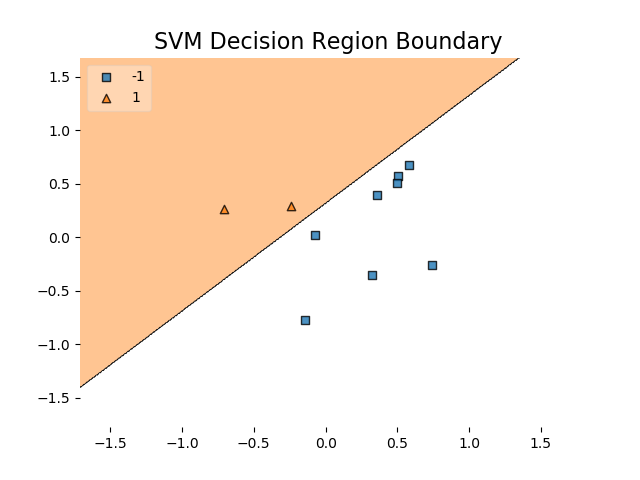

In [28]:
# Plotting the SVM Decision Boundary
plot_decision_regions(X=data_complete[:,1:3], 
                      y=(data_complete[:,3]).astype(np.integer),
                      clf=clf, 
                      legend=2)
plt.title('SVM Decision Region Boundary', size=16)
plt.show()

The decision boundary is a linear combination of the support vectors where the alphas are computed via optimizing the dual lagrangian. The prediction for any given x is different for SVM's case because any point lying within the margins or the two extreme support vectors is counted as error and the points belonging to the sides of support vectors are classified as +1 or -1 respectively. For PLA, it is pretty straighforward and our self coded prediction function works but for SVM it is much better to use the inbuilt scikit learn methods for computing various attribubtes of the fitted model.